<a href="https://colab.research.google.com/github/ThePyProgrammer/PXChallenge/blob/master/PX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the model for Covid-19 Cases: Singapore
## Written by Prannaya Gupta
### Part of PX Challenge 2020

###Imports and Preparation of data

,date,cases
0,2019-12-31,0.0
1,2020-01-01,0.0
2,2020-01-02,0.0
3,2020-01-03,0.0
4,2020-01-04,0.0
5,2020-01-05,0.0
6,2020-01-06,0.0
7,2020-01-07,0.0
8,2020-01-08,0.0
9,2020-01-09,0.0


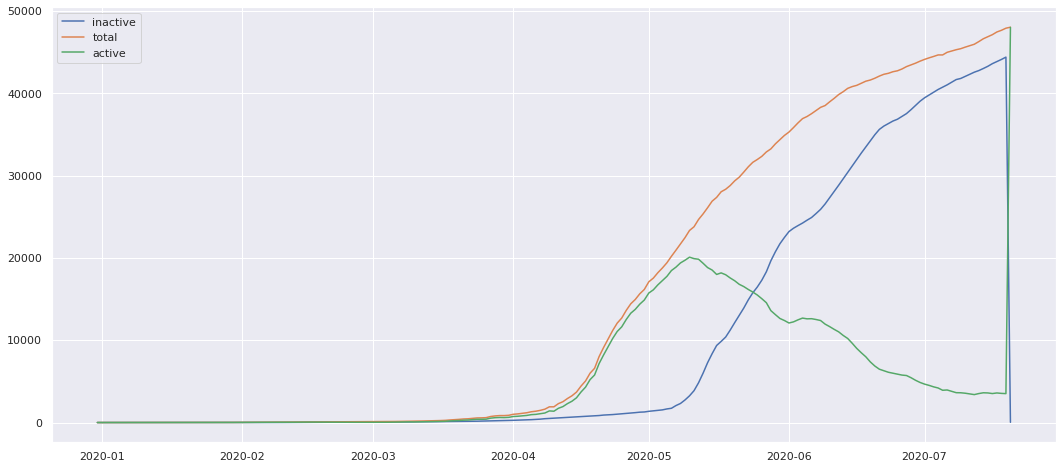

In [133]:
import numpy as np # main library for numeric calculations
import pandas as pd # main library for data analysis
import matplotlib.pyplot as plt # main library for data plotting
import seaborn as sns
sns.set() # mainly to set style of the plot

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error #technically not used

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product
from datetime import datetime, date, timedelta
from fbprophet import Prophet

def mean_absolute_percentage_error(y_true, y_pred): # MAPE scoring system for scoring time series forecasting
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore') # literally to ignore all the warning that don't matter

%matplotlib inline
# to place plotting inside the diagram


data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv') # main data
data2 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv') # R section of the SIR model


def find(country='Singapore', kind='new_cases', name=None): # program to retrieve data required from the main data
    return pd.DataFrame([[datetime.date(datetime.strptime(i[1], "%Y-%m-%d")), i[-1]] for i in list(data[['location','date',kind]].to_numpy()) if i[0] == country], columns=['date', kind if name is None else name])
#                                   ^ is just to process the date given                                  ^ takes in where, when and what           ^ parses out country               ^ if name is specified it gives name else just uses the name given beforehand

def find2(): # program to retrieve data required from the main data
    ser = data2.transpose().drop(['Province/State', 'Lat', 'Long'])[194]
    df = pd.DataFrame({"date":pd.to_datetime(ser.index[1:]).date, "cases": ser.values[1:]}, columns=["date", "cases"])
    return df


    #return pd.DataFrame([[datetime.date(datetime.strptime(i[1], "%Y-%m-%d")), i[-1]] for i in list(data2[['location','date',kind]].to_numpy()) if i[0] == country], columns=['date', kind if name is None else name])
#                                   ^ is just to process the date given                                  ^ takes in where, when and what           ^ parses out country               ^ if name is specified it gives name else just uses the name given beforehand


sgdata = find(name='cases') # new cases every day
sgtotal = find(kind='total_cases', name='cases') # total cases per day
sgdeaths = find(kind='new_deaths', name='deaths') # new deaths every day
sgtotaldeaths = find(kind='total_deaths', name='deaths') # total deaths per day
sgdatapm = find(kind='new_cases_per_million', name='cases') # new cases per million every day
sgtotalpm = find(kind='total_cases_per_million', name='cases') # total cases per million per day
sgdeathspm = find(kind='new_deaths_per_million', name='deaths') # new deaths per million every day
sgtotaldeathspm = find(kind='total_deaths_per_million', name='deaths') # total deaths per million per day
sgpop = find(kind='population', name='pop') # population
sgpopdensity = find(kind='population_density', name='density') # population density
sgrecovered = find2()

# method tactic: time series analysis


xog = x = sgdata['date'].to_numpy()[:-1][:, np.newaxis] # gets the x-axis: dates
y = sgdata['cases'].to_numpy()[1:][:, np.newaxis] # gets the y-axis: cases
x = np.vectorize(lambda xval: (xval-x[0][0]).days+1)(x) # gets the days since 31 Jul 2020



# This step is to account for the shift in data due to delay in reporting of data by OWID
sgdata = pd.DataFrame({'date': sgdata['date'].to_numpy()[:-1], 'cases': sgdata['cases'].to_numpy()[1:]})
sgtotal = pd.DataFrame({'date': sgtotal['date'].to_numpy()[:-1], 'cases': sgtotal['cases'].to_numpy()[1:]})
sgdeaths = pd.DataFrame({'date': sgdeaths['date'].to_numpy()[:-1], 'deaths': sgdeaths['deaths'].to_numpy()[1:]})
sgtotaldeaths = pd.DataFrame({'date': sgtotaldeaths['date'].to_numpy()[:-1], 'deaths': sgtotaldeaths['deaths'].to_numpy()[1:]})
sgdatapm = pd.DataFrame({'date': sgdatapm['date'].to_numpy()[:-1], 'cases': sgdatapm['cases'].to_numpy()[1:]})
sgtotalpm = pd.DataFrame({'date': sgtotalpm['date'].to_numpy()[:-1], 'cases': sgtotalpm['cases'].to_numpy()[1:]})
sgdeathspm = pd.DataFrame({'date': sgdeathspm['date'].to_numpy()[:-1], 'deaths': sgdeathspm['deaths'].to_numpy()[1:]})
sgtotaldeathspm = pd.DataFrame({'date': sgtotaldeathspm['date'].to_numpy()[:-1], 'deaths': sgtotaldeathspm['deaths'].to_numpy()[1:]})
sgpop = pd.DataFrame({'date': sgpop['date'].to_numpy()[:-1], 'pop': sgpop['pop'].to_numpy()[1:]})
sgpopdensity = pd.DataFrame({'date': sgpopdensity['date'].to_numpy()[:-1], 'density': sgpopdensity['density'].to_numpy()[1:]})
sgrecovered = pd.DataFrame({'date': sgrecovered['date'].to_numpy()[:-1], 'cases': sgrecovered['cases'].to_numpy()[1:]})
#

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

allsg = np.array([sgdata['date'], sgdata['cases'], sgtotal['cases'], sgdeaths['deaths'], sgtotaldeaths['deaths'], sgdatapm['cases'], sgtotalpm['cases'], sgdeathspm['deaths'], sgtotaldeathspm['deaths'], sgpop['pop'], sgpopdensity['density']]).T
sg = pd.DataFrame(allsg, index=sgdata['date'], columns=['date', 'new cases', 'total cases', 'new deaths', 'total deaths', 'new cases per million', 'total cases per million', 'new deaths per million', 'total deaths per million', 'population', 'population density'])


#plt.plot(sgrecovered['cases'].to_numpy())
recoveredtemp = sgrecovered.copy()
recoveredtemp.columns = ["date", "cases"]
deathstemp = sgtotaldeaths.copy()
deathstemp.columns = ["date", "cases"]
sginactive = recoveredtemp.set_index("date").add(deathstemp.set_index("date"), fill_value=0).reset_index().fillna(0)
sgactive = sgtotal.set_index("date").sub(sginactive.set_index("date"), fill_value=0).reset_index().fillna(0)
plt.figure(figsize=(18,8))
plt.plot(sginactive['date'], sginactive['cases'], label="inactive")
plt.plot(sgtotal['date'], sgtotal['cases'], label="total")
plt.plot(sgactive['date'], sgactive['cases'], label="active")
plt.legend()
sgactive

### Testing of data

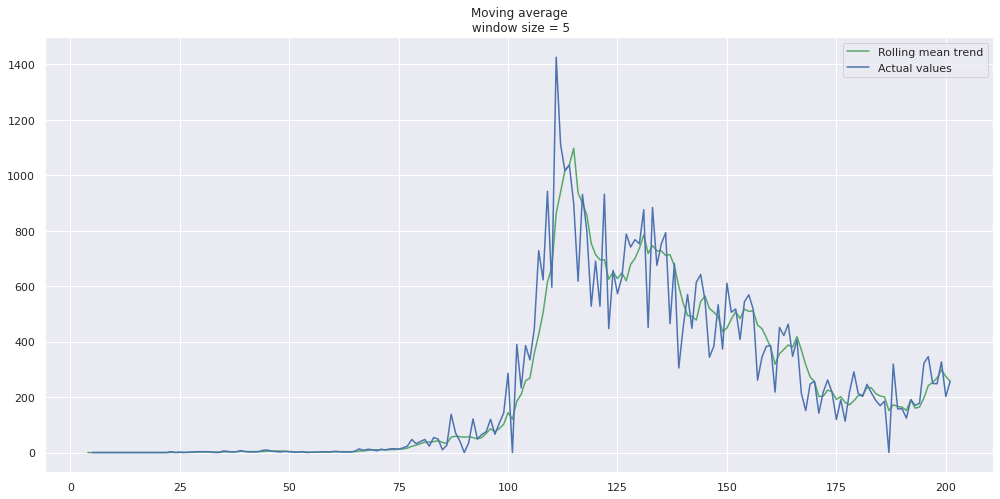

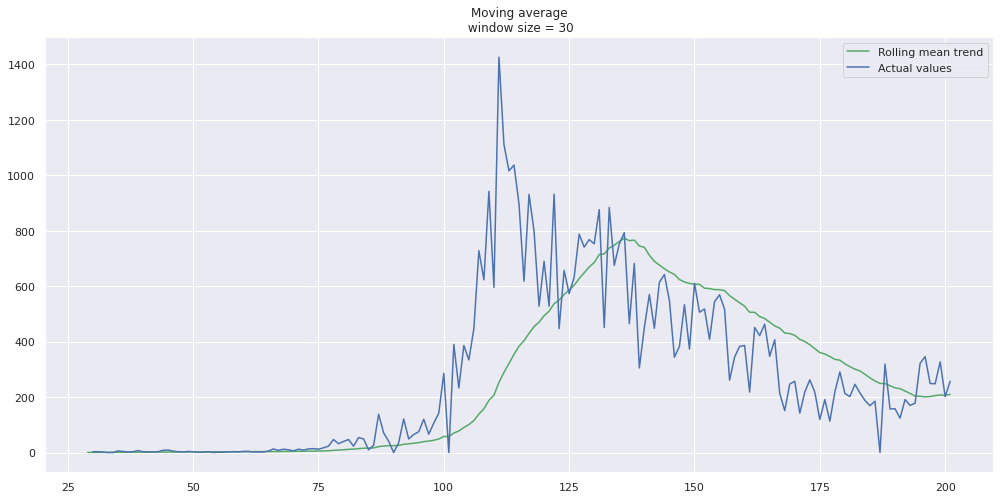

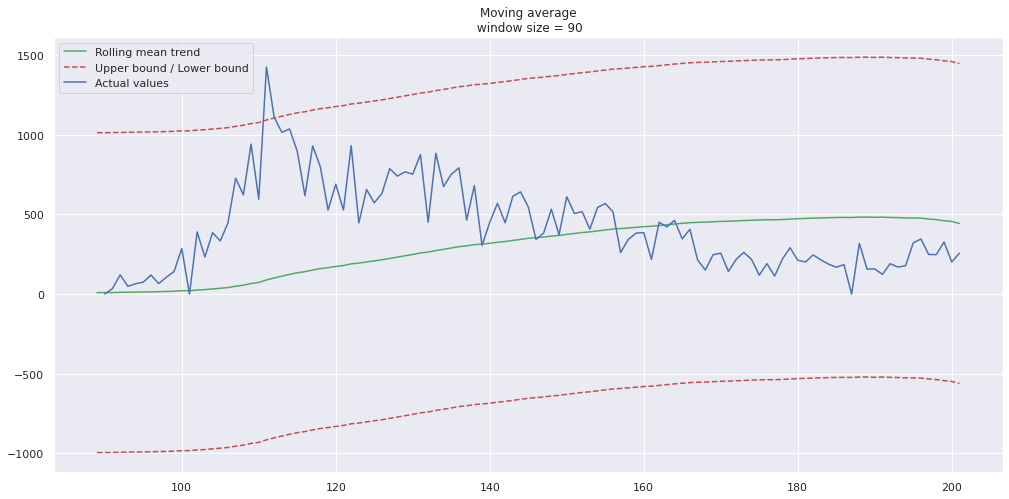

In [102]:
# Code ripped from https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean() # calculates the moving average

    plt.figure(figsize=(17, 8)) # modifies the size of the plot
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_moving_average(sgdata['cases'], 5) #Smooth by the previous 5 days (by week)
plot_moving_average(sgdata['cases'], 30) #Smooth by the previous month (30 days)
plot_moving_average(sgdata['cases'], 90, plot_intervals=True) #Smooth by previous quarter (90 days)

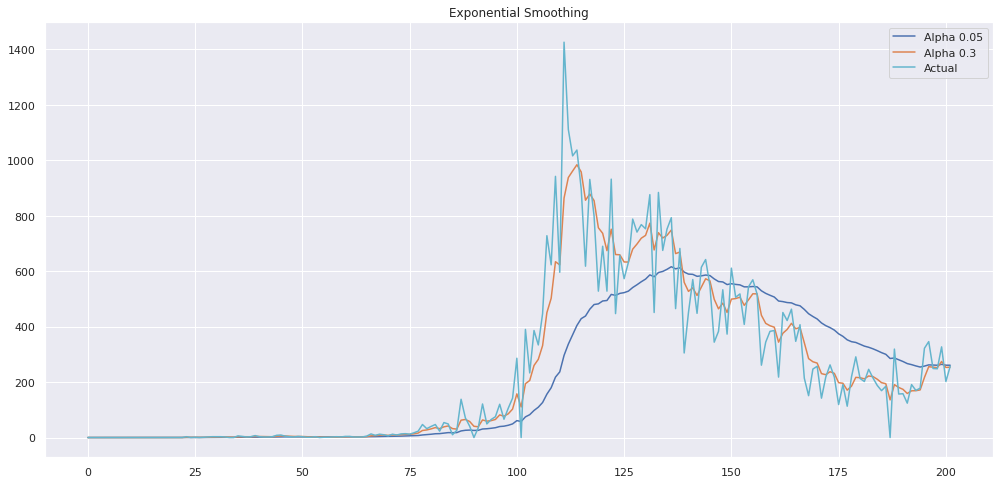

In [103]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
    plt.show()

plot_exponential_smoothing(sgdata['cases'], [0.05, 0.3])

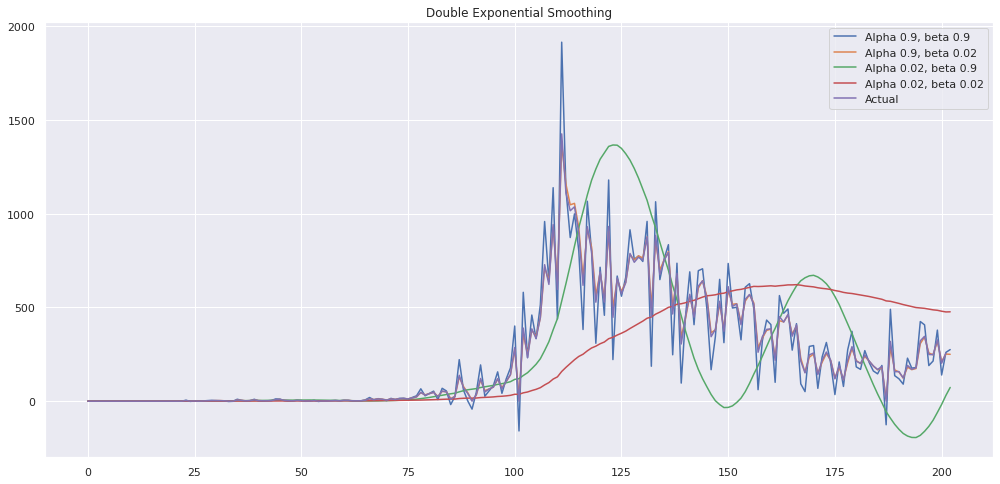

In [104]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    plt.show()
    
plot_double_exponential_smoothing(sgdata['cases'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

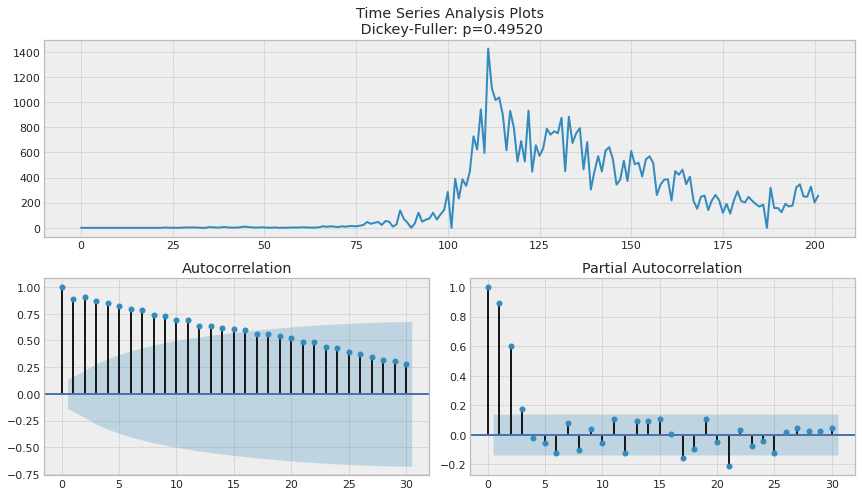

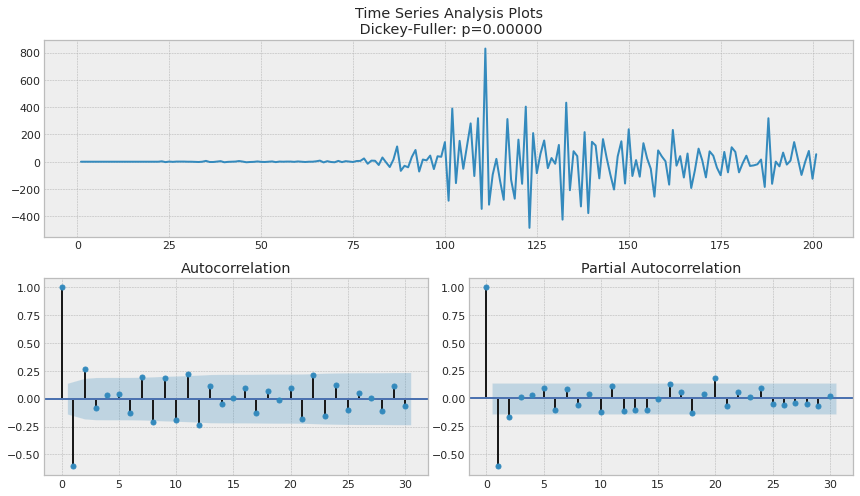

In [105]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        

tsplot(sgdata['cases'], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = sgdata['cases'] - sgdata['cases'].shift(1)

tsplot(data_diff[1:], lags=30)

plt.show()

### ARIMA Prediction

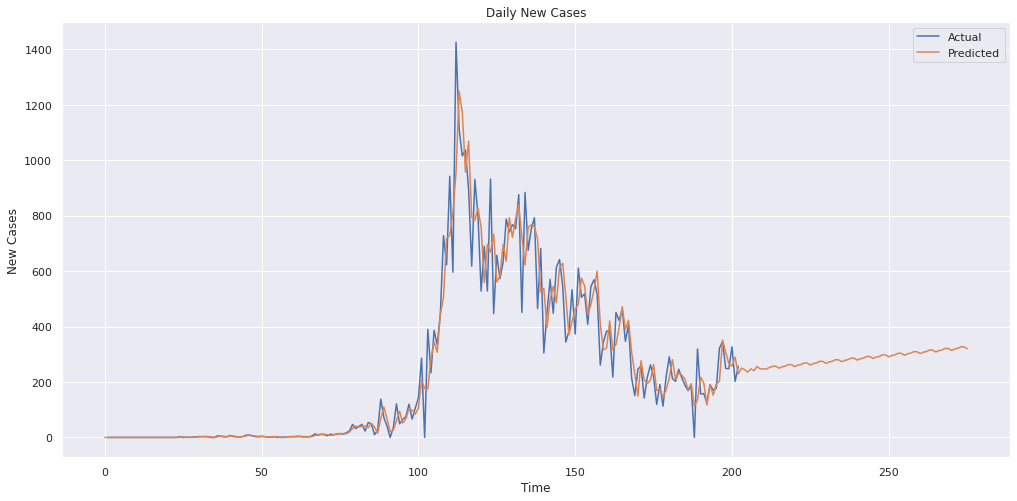

array([228.75119019, 250.02422171, 244.88827105, 235.40772666,
       247.28565809, 241.10738754, 255.57185928, 247.20524351,
       246.6990864 , 247.11143157, 252.63441842, 256.5596737 ,
       256.85001845, 249.79709159, 254.74282784, 257.46233518,
       262.82649455, 262.66815101, 255.41178105, 260.93477874,
       262.91412948, 269.03492183, 268.19433352, 261.49887038,
       266.59731003, 268.87095345, 274.80948784, 274.06270555,
       267.3376821 , 272.42332134, 274.73409368, 280.62484867,
       279.92699152, 273.15780414, 278.27978564, 280.56302567,
       286.47288492, 285.76317917, 279.00010699, 284.12014155,
       286.40257691, 292.31482411, 291.60203412, 284.84212547,
       289.95930119, 292.24409122, 298.15455298, 297.44300315,
       290.68232424, 295.79989858, 298.08456042, 303.99497164,
       303.28357538, 296.52269738, 301.64047628, 303.92495306,
       309.83551684, 309.1240048 , 302.3632073 , 307.48093613,
       309.76543889, 315.67599423, 314.96447902, 308.20

In [112]:
# code ripped from https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
# forecasting using ARIMA

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(sgdata['cases'], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(sgdata['cases'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)


plt.figure(figsize=(17, 8))
predX = np.hstack((sgdata.index, best_model.forecast(74).index))[:, np.newaxis]
predY = np.hstack((best_model.fittedvalues, best_model.forecast(74)))[:, np.newaxis]
plt.plot(x, y, label="Actual")
plt.plot(predX, predY, label="Predicted")
plt.xlabel("Time")
plt.ylabel("New Cases")
plt.title("Daily New Cases")
plt.legend(loc="best")
plt.show()

best_model.forecast(74).values

### Double Exponential Smoothing (modified) Prediction

array([[136.86111156, 136.68175123, 143.62234196, 113.67224171,
         94.05626976, 108.35185878, 111.21498829,  87.36118637,
        105.82250115,  97.58312496, 126.63888807, 127.87025861,
         96.80793222,  81.83760846,  83.8998925 , 101.22552047,
        105.69331081,  97.03375183, 101.76984951, 105.66394594,
        102.15519958,  91.45564279,  72.87553202,  76.28973314,
         95.36504282, 106.08610555, 100.48837341,  88.67093206,
         86.21899321,  86.24422615,  80.18850336,  75.04925087,
         76.99012881,  89.11357366, 100.0331298 ,  94.21884887,
         78.61687858,  69.71485956,  72.40247577,  77.24600732,
         77.5866517 ,  78.78170145,  83.79497926,  87.32205442,
         82.51673087,  69.74961579,  60.94738533,  64.92841424,
         75.15948029,  80.17793567,  78.06103004,  75.11522744,
         73.56375333,  69.71897183,  62.98049124,  58.87608144,
         63.04258787,  72.78354171,  78.03575256,  73.70297096,
         65.39024005,  60.61747223,  59.

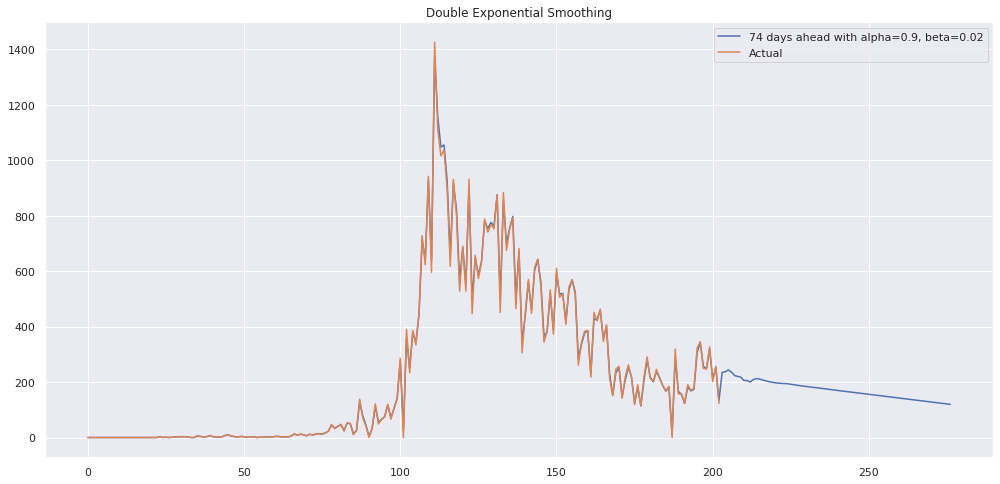

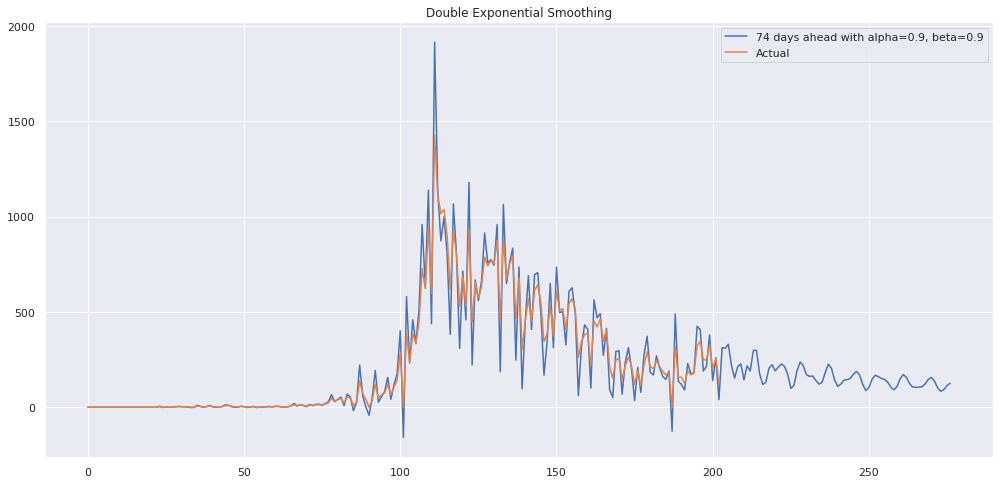

In [134]:
# algo modified for prediction
# Written by Prannaya Gupta (20 July 2020)

def exp2_smoothing(alpha=0.9, beta=0.02, how_ahead=74):
  def double_exponential_smoothing(series, alpha, beta, how_ahead=1, days_prev_to_consider=None):
      if days_prev_to_consider is None: days_prev_to_consider = how_ahead
      history = [[series[0], series[1] - series[0]]]
      result = [series[0]]
      for n in range(1, len(series)+how_ahead):
          if n == 1:
              level, trend = series[0], series[1] - series[0]
          if n >= len(series): # forecasting
              #value = result[-1]
              res = 0
              for i in range(days_prev_to_consider):
                  [lvl, trnd] = history[-days_prev_to_consider:][i]
                  res += lvl + (days_prev_to_consider-i)*trnd
              
              value = res/days_prev_to_consider
              last_level, level = level, alpha * (result[-1]+value)/2 + (1 - alpha) * (level + trend)
              trend = beta * (level - last_level) + (1 - beta) * trend
              result.append(value)
              history.append([level, trend])
              continue
          else:
              value = series[n]
          last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
          trend = beta * (level - last_level) + (1 - beta) * trend
          result.append(level + trend)
          history.append([level, trend])
      return [result, history]

  def plot_double_exponential_smoothing(series, alpha, beta, how_ahead=1):
      plt.plot(double_exponential_smoothing(series, alpha, beta, how_ahead)[0][1:], label="{} days ahead".format(how_ahead))
      
      #plt.show()


  [ypred, history] = double_exponential_smoothing(sgdata['cases'], alpha=alpha, beta=beta, how_ahead=74, days_prev_to_consider=10)

  def plot_2exp_smoothing_best(start=1, how_ahead=how_ahead, days_prev_to_consider=10, sep=10):
    for i in range(start, how_ahead+1):
      if (i-1) // (sep) > (i-2)//(sep) or i == 1: 
        plt.figure(figsize=(17, 8))
      plt.plot(double_exponential_smoothing(sgdata['cases'], alpha, beta, i, days_prev_to_consider)[0], label="{} days ahead with alpha={}, beta={}".format(i, alpha, beta))
      if (i-1) // (sep) < (i)//(sep) or i == how_ahead: 
        plt.plot(sgdata['cases'].values, label = "Actual")
        plt.legend(loc="best")
        plt.title("Double Exponential Smoothing")
        #plt.grid(True)

  plot_2exp_smoothing_best(how_ahead, how_ahead, sep=how_ahead-1)
  return np.array(ypred[-74:])

alphas=[0.02, 0.9]
betas=[0.02, 0.9]
how_ahead=74
exp2 = np.zeros((1, 74))
for alpha in alphas:
  for beta in betas:
    if alpha == 0.02: continue
    exp2 += exp2_smoothing(alpha, beta, 74)
exp2/= (len(alphas)*len(betas))
exp2

### Predicting using Prophet

In [135]:
# modification of DataFrame to form a dataset for prophet

sgdatadf = pd.DataFrame({'ds': sgdata['date'], 'y': sgdata['cases']})
sgtotaldf = pd.DataFrame({'ds': sgtotal['date'], 'y': sgtotal['cases']})
sgdeathsdf = pd.DataFrame({'ds': sgdeaths['date'], 'y': sgdeaths['deaths']})
sgtotaldeathsdf = pd.DataFrame({'ds': sgtotaldeaths['date'], 'y': sgtotaldeaths['deaths']})
sgdatapmdf = pd.DataFrame({'ds': sgdatapm['date'], 'y': sgdatapm['cases']})
sgtotalpmdf = pd.DataFrame({'ds': sgtotalpm['date'], 'y': sgtotalpm['cases']})
sgdeathspmdf = pd.DataFrame({'ds': sgdeathspm['date'], 'y': sgdeathspm['deaths']})
sgtotaldeathspmdf = pd.DataFrame({'ds': sgtotaldeathspm['date'], 'y': sgtotaldeathspm['deaths']})
sgpopdf = pd.DataFrame({'ds': sgpop['date'], 'y': sgpop['pop']})
sgpopdensitydf = pd.DataFrame({'ds': sgpopdensity['date'], 'y': sgpopdensity['density']})

sgdatadf

,ds,y
0,2019-12-31,0.0
1,2020-01-01,0.0
2,2020-01-02,0.0
3,2020-01-03,0.0
4,2020-01-04,0.0
5,2020-01-05,0.0
6,2020-01-06,0.0
7,2020-01-07,0.0
8,2020-01-08,0.0
9,2020-01-09,0.0


,y
count,203.000000
mean,236.625616
std,290.705114
min,0.000000
25%,3.000000
50%,121.000000
75%,398.500000
max,1426.000000


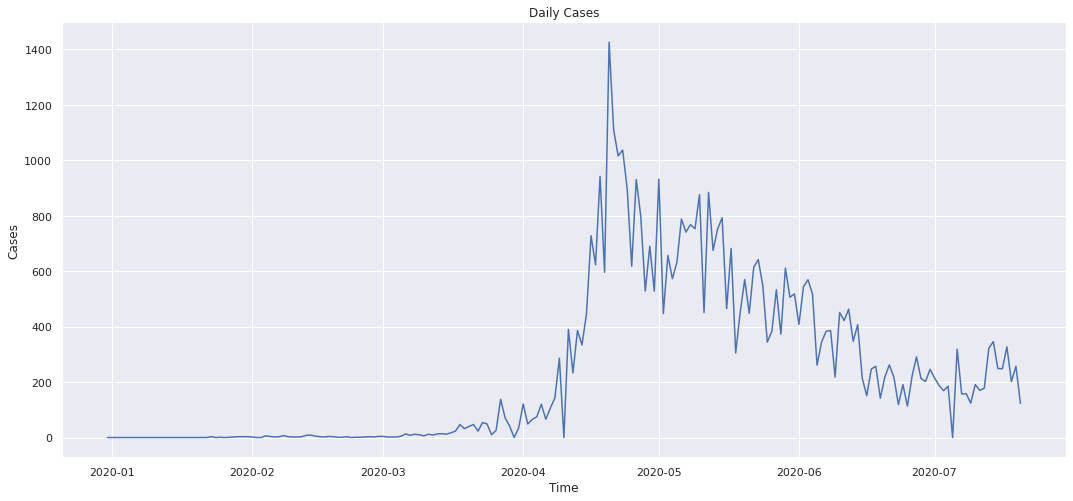

In [136]:
# Experimenting with the Dataframes made for Prophet

plt.figure(figsize=[18,8])
plt.plot(sgdatadf['ds'], sgdatadf['y'])
plt.title("Daily Cases")
plt.ylabel("Cases")
plt.xlabel("Time")
sgdatadf.describe()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


array([250.27693248, 286.160264  , 286.21503332, 308.7022211 ,
       299.15641302, 315.23557563, 312.82117989, 321.33769862,
       357.0709684 , 355.60156778, 375.10878687, 361.08474189,
       371.18758439, 361.34379292, 361.06847222, 386.78309023,
       374.24678839, 381.85686877, 355.35808494, 352.6898023 ,
       330.08117199, 317.3634357 , 331.27901413, 307.90376162,
       305.93825413, 271.40801067, 262.50198803, 235.65976008,
       220.87675058, 235.00740126, 214.18285596, 217.09919009,
       189.71620565, 190.09620541, 174.49318294, 172.661772  ,
       201.16576188, 195.80263521, 214.89998802, 204.02364109,
       220.82660959, 221.14909218, 234.33852631, 276.56920652,
       283.27760871, 312.46897134, 309.43464772, 331.60912445,
       334.67662541, 347.89614473, 387.42424591, 388.75166023,
       410.00917769, 396.6823426 , 406.46390192, 395.35403345,
       392.97735713, 415.89627408, 400.0369164 , 403.98348653,
       373.68081149, 367.27439259, 341.19831972, 325.48

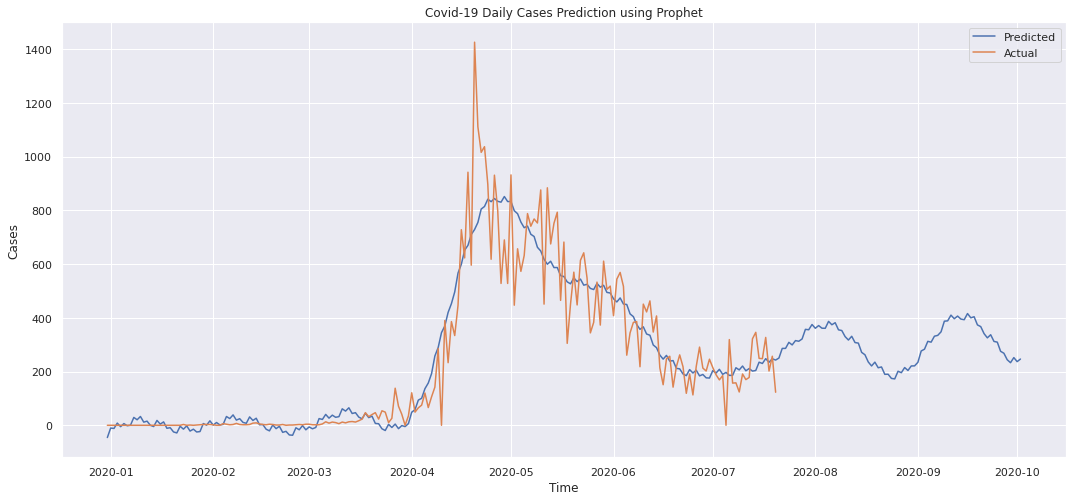

In [137]:
df = sgdatadf
plt.figure(figsize=(18,8))
my_model = Prophet(yearly_seasonality=True)
my_model.fit(df)
future_dates = my_model.make_future_dataframe(periods=74, freq='D')
future_dates.tail()
forecast = my_model.predict(future_dates)
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted")
plt.plot(sgdata['date'], sgdata['cases'], label = "Actual")
plt.legend(loc="best")
plt.title("Covid-19 Daily Cases Prediction using Prophet")
plt.ylabel("Cases")
plt.xlabel("Time")
preds = forecast[['ds', 'yhat']].iloc[sgdata.shape[0]:]
dates = preds['ds'].to_numpy()
preds = preds['yhat'].to_numpy()
preds

###Evaluation of Data
We use all previous predictions and evaluate an average to form an overall prediction.

,cases
2020-07-21,205
2020-07-22,224
2020-07-23,225
2020-07-24,219
2020-07-25,213
2020-07-26,222
2020-07-27,227
2020-07-28,219
2020-07-29,237
2020-07-30,233


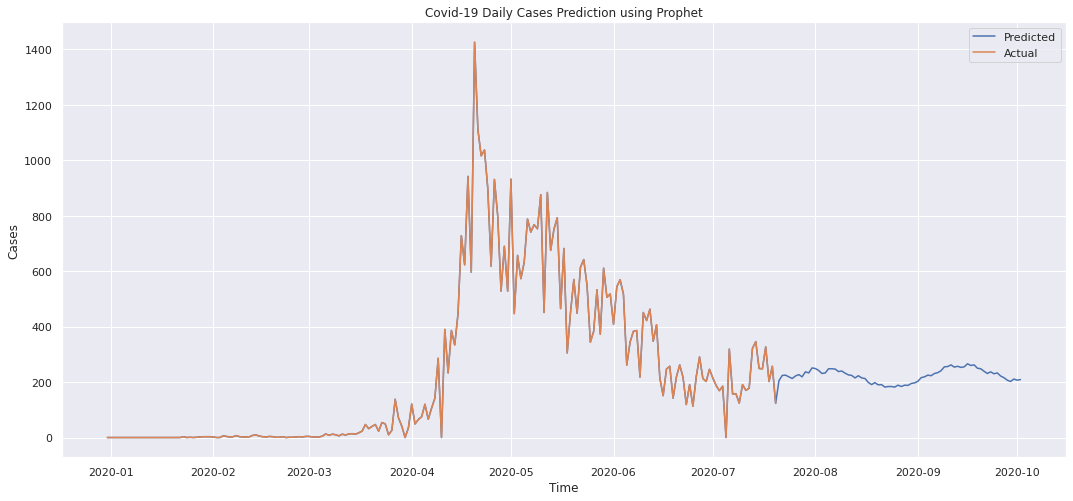

In [138]:
prediction = pd.DataFrame(np.round((preds+exp2+best_model.forecast(74).values)/3)[0].astype(np.int64), index=pd.to_datetime(dates).date, columns=["cases"])

plt.figure(figsize=(18,8))
plt.plot(np.hstack((sgdata['date'].to_numpy(), prediction.index.to_numpy())), np.hstack((sgdata['cases'].to_numpy(), prediction.values.T[0])), label="Predicted")
plt.plot(sgdata['date'], sgdata['cases'], label = "Actual")
plt.legend(loc="best")
plt.title("Covid-19 Daily Cases Prediction using Prophet")
plt.ylabel("Cases")
plt.xlabel("Time")

prediction #.cumsum().add(sgtotal['cases'].iloc[-1])

###The SIR Model
S = Susceptible

I = Infected

R = Recovered

Text(0.5, 0, 'Time')

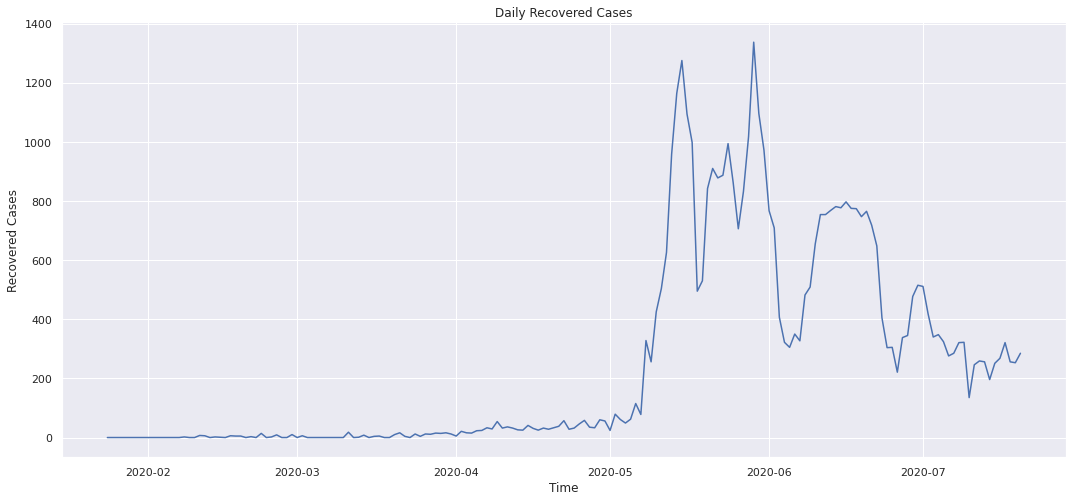

In [120]:
sgnewrecover = pd.DataFrame({'date': np.hstack((sgrecovered['date'].iloc[2:].to_numpy(), np.array([sgrecovered['date'].iloc[-1]+timedelta(days=1)]))), 'cases': sgrecovered.diff()['cases'].iloc[1:].to_numpy()})

line = sgnewrecover.plot(x='date', y='cases', title='Daily Recovered Cases', figsize=(18,8), legend=False)
ax = line.axes
ax.set_ylabel("Recovered Cases")
ax.set_xlabel("Time")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2020-08-13    173.804179
2020-08-14    139.202070
2020-08-15    97.468008 
2020-08-16    66.125407 
2020-08-17    20.391122 
2020-08-18    2.082438  
2020-08-19    25.410469 
2020-08-20    43.085792 
2020-08-21    64.793470 
2020-08-22    82.287191 
2020-08-23    111.609343
2020-08-24    126.440960
2020-08-25    167.049298
2020-08-26    246.122582
2020-08-27    314.916651
2020-08-28    381.769487
2020-08-29    437.232296
2020-08-30    496.322909
2020-08-31    531.904507
2020-09-01    583.656606
2020-09-02    663.927169
2020-09-03    723.890049
2020-09-04    772.063422
2020-09-05    799.437713
2020-09-06    821.718845
2020-09-07    812.690025
2020-09-08    813.159452
2020-09-09    836.783400
2020-09-10    836.189638
2020-09-11    821.457752
2020-09-12    785.205899
2020-09-13    744.790910
2020-09-14    675.626132
2020-09-15    620.085595
2020-09-16    593.285116
2020-09-17    549.166486
2020-09-18    498.942345
2020-09-19    436.152269
2020-09-20    378.837842
2020-09-21    302.841779


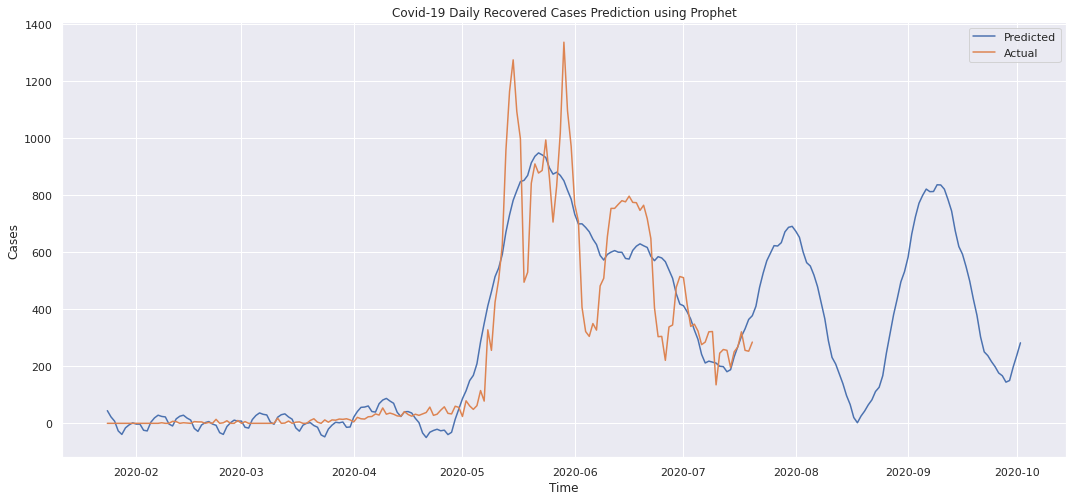

In [131]:
df = pd.DataFrame({'ds': sgnewrecover['date'], 'y': sgnewrecover['cases']})
plt.figure(figsize=(18,8))
my_model = Prophet(yearly_seasonality=True)
my_model.fit(df)
future_dates = my_model.make_future_dataframe(periods=74, freq='D')
future_dates.tail()
forecast = my_model.predict(future_dates)
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted")
plt.plot(sgnewrecover['date'], sgnewrecover['cases'], label = "Actual")
plt.legend(loc="best")
plt.title("Covid-19 Daily Recovered Cases Prediction using Prophet")
plt.ylabel("Cases")
plt.xlabel("Time")
preds = forecast[['ds', 'yhat']].iloc[sgdata.shape[0]:]
dates = preds['ds'].to_numpy()
preds = preds['yhat'].copy()
preds.index = dates
preds